<a href="https://colab.research.google.com/github/coegoke/Investigate-Netflix-Movie/blob/main/Investigate_Netflix_Movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Netflix Movie Data

This dataset contains more than 8,500 Netflix movies and TV shows, including cast members, duration, and genre. It contains titles added as recently as late September 2021.

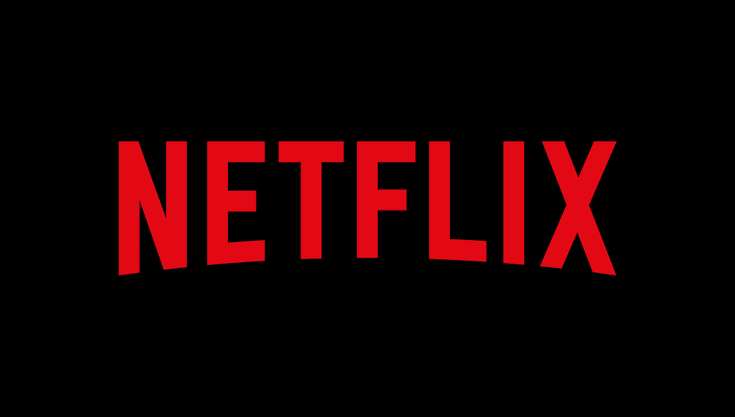


# Business Question
1. Berapa persen dari setiap tipe konten netflix?
2. Siapa director yang paling sering membuat film?
3. Negara mana yang paling sering membuat film?
4. bagaimana trend release film berdasarkan tipe film?
5. rating apa yang paling banyak digemari?
6. berapa durasi film yang paling banyak ditonton berdasarkan waktu dan season?
7. sebaran waktu semua film yang rilis?
8. sebaran film yang berdurasi panjang berdasarkan negara?

## Import Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/coegoke/Investigate-Netflix-Movie/main/netflix_dataset.csv")

## Data Exploration

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
df.shape

(8807, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [6]:
df.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


#Data Preprocessing

## Data Cleaning

In [7]:
# Number of missing values
num_null = df.isnull().sum()

# percentage null values
pct_null = round((num_null/df.shape[0] * 100), 2)

# Create dataframe for number of null value and percentage of null values
df_null = pd.DataFrame({
    'Null Values':num_null,
    'Percentage':pct_null}).reset_index()

# Rename column index to Feature 
df_null.rename(columns={'index':'Features'}, inplace=True)

# Filter only features with null values and sort as descending
df_null = df_null[df_null['Null Values'] > 0].sort_values('Null Values', ascending=False).reset_index(drop=True)
df_null

,Features,Null Values,Percentage
0,director,2634,29.91
1,country,831,9.44
2,cast,825,9.37
3,date_added,10,0.11
4,rating,4,0.05
5,duration,3,0.03


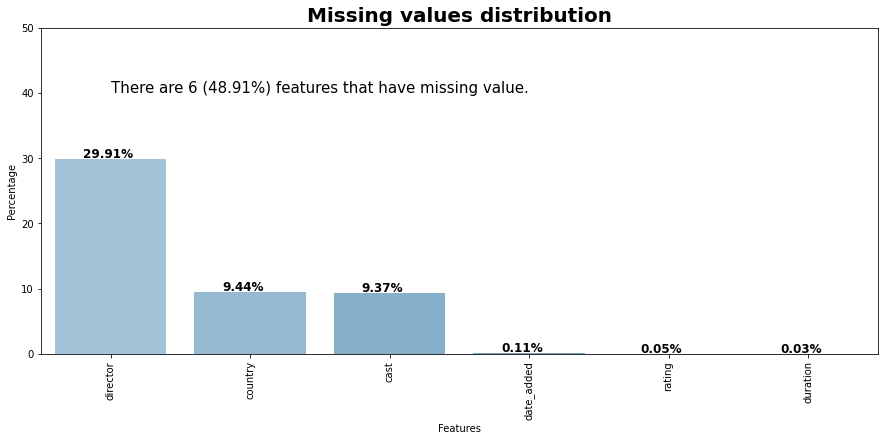

In [8]:
# Plotting number of missing data
fig, ax = plt.subplots(figsize=(15,6))

g = sns.barplot(x = 'Features',y='Percentage',data=df_null,ax=ax, 
               palette=sns.color_palette("Blues_d", n_colors=13, desat=1))

# percentage of missing values
x = np.arange(len(df_null['Features']))
y = df_null['Percentage']

for i, v in enumerate(y):
    ax.text(x[i]-0.2, v+0.2, str(v)+'%', fontsize = 12, color='black', fontweight='bold')
    
text = 'There are '+str(len(df_null.Features)) +' ('+str(df_null.Percentage.sum())+'%) features that have missing value.'

ax.text(0,40,text,horizontalalignment='left',color='black',fontsize=15, fontweight='normal')
ax.set_title('Missing values distribution', color='black', fontsize=20, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(0,50)
plt.show()

### Handling Missing Value dan duplikat data
1. Country - mengganti negara kosong dengan negara paling banyak
2. Cast - mengganti nan value dengan 'Data tidak tersedia'
3. Director - mengganti nan value dengan 'Data tidak tersedia'
4. kolom lainnya akan dihapus karena hanya sedikit datanya

In [9]:
df['country'] = df['country'].fillna(df['country'].mode()[0])

df['cast'].replace(np.nan, 'No Data',inplace  = True)
df['director'].replace(np.nan, 'No Data',inplace  = True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

## Update Value Data
1. Rating - mengganti beberapa isi kolom sesuai dengan data netflix

In [10]:
df.rating.unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', 'NR', 'TV-Y7-FV', 'UR'], dtype=object)

In [11]:
df.rating = df.rating.replace({
                'PG-13': 'Teens - Age above 12',
                'TV-MA': 'Adults',
                'PG': 'Kids - with Parental guidence',
                'TV-14': 'Teens - Age above 14',
                'TV-PG': 'Kids - with Parental guidence',
                'TV-Y': 'Kids',
                'TV-Y7': 'Kids - Age above 7',
                'R': 'Adults',
                'TV-G': 'Kids',
                 'G': 'Kids',
                'NC-17': 'Adults',
                'NR': 'NR',
                'UR' : 'UR'
})

In [12]:
df.rating.unique()

array(['Teens - Age above 12', 'Adults', 'Kids - with Parental guidence',
       'Teens - Age above 14', 'Kids', 'Kids - Age above 7', 'NR',
       'TV-Y7-FV', 'UR'], dtype=object)

# EDA

##Berapa persen dari setiap tipe Konten Netflix?

In [13]:
fig = go.Figure()
fig = fig.update_layout(title_font_color="red",
        template = {'data' : {'indicator': [{
        'title': {'text': "Total content on Netflix"},}]
        }})

fig = fig.update_layout(
    #autosize=False,
    #width=500,
    height=100,
    margin=dict(l=50,r=50,b=0,t=1),title_font_color="red")

fig.show()


df_type = df.groupby('type')['show_id'].count().reset_index()
df_type = df_type.rename(columns = {"show_id":"count_showids"})
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'bar'}, {'type':'pie'}]])
fig.add_trace(
    
    go.Bar(x= df_type['count_showids'], y= df_type['type'], orientation = 'h', marker=dict(color=["Maroon", "black"]), showlegend=False, 
           text = df_type['count_showids'], textposition='auto'),
    row=1, col=1)

fig.add_trace(
    
    go.Pie(labels=df_type['type'], values=df_type['count_showids'], marker_colors= ["Maroon", "Black"],textinfo='label+percent',pull=[0,0.1]),
    row=1, col=2)

fig.update_layout(
    title_text="What type of content is more uploaded more on Netflix?", title_font_color="red")
fig.show(renderer='colab')

##2. Siapa director yang paling sering membuat film?

In [14]:
df1 = df.director.value_counts()
df1 = df1.drop('No Data')
df1 = df1.head(10).sort_values()
fig = go.Figure()
fig.add_trace(go.Bar(x=df1,y=df1.index,text=df1
              ,marker_color='maroon', orientation = 'h'))
fig.update_traces(texttemplate='%{text} Content')
fig.update_layout(
    title='Most Content Director in Netflix',title_font_color="maroon",title_font_size=32,height=500,
     xaxis_tickfont_size=14,xaxis_tickfont_color='maroon',xaxis_title='Content',xaxis_titlefont_color='maroon',
    yaxis=dict(
        title='Director',
        titlefont_size=16,
        tickfont_size=14,
        titlefont_color='maroon',
        tickfont_color='maroon'
    ))
fig.show()

In [15]:
df3 = df.groupby(['director','type'])['show_id'].count().reset_index().sort_values(by='show_id',ascending=False).head(12).iloc[2:].sort_values(by='show_id')
fig = go.Figure()
fig.add_trace( go.Bar(name='Movie',marker_color='maroon',x= df3[df3['type']=='Movie']['show_id'], y= df3[df3['type']=='Movie']['director'], orientation = 'h'))
fig.update_traces(texttemplate='%{text:} ss')
fig.add_trace( go.Bar(name='TV Show',marker_color='Black',x= df3[df3['type']=='TV Show']['show_id'], y= df3[df3['type']=='TV Show']['director'], orientation = 'h'))
fig.update_layout(barmode='stack',title='Most Content Director in Netflix',title_font_color="maroon",title_font_size=32,height=500,
     xaxis_tickfont_size=14,xaxis_tickfont_color='maroon',xaxis_title='Content',xaxis_titlefont_color='maroon',
    yaxis=dict(
        title='Director',
        titlefont_size=16,
        tickfont_size=14,
        titlefont_color='maroon',
        tickfont_color='maroon'
    ))

fig.show()

##3. Negara mana yang paling sering membuat film?

In [23]:
df2 = df.country.value_counts()
df2 = df2.head(10)
fig = go.Figure()
fig.add_trace(go.Bar(x=df2.index,y=df2,text=df2
              ,marker_color='maroon', name='Content'))
fig.update_layout(
    title='Most Country Production in Content Netflix',title_font_color="maroon",title_font_size=32,
    xaxis_tickfont_size=14,xaxis_tickfont_color='red',
    yaxis=dict(
        title='Content',
        titlefont_size=16,
        tickfont_size=14,
    ))
fig.update_traces(texttemplate='%{text:} Content', textposition='outside')
fig.show(renderer='colab')

##4.bagaimana trend release film berdasarkan tipe film?

In [17]:
df4 = df.groupby(['release_year','type'])['show_id'].count().reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(name='TV Show',x=df4[df4['type'] == 'TV Show']['release_year'], y=df4[df4['type'] == 'TV Show']['show_id'],
                         line=dict(color='maroon', width=2)))
fig.add_trace(go.Scatter(name='Movie',x=df4[df4['type'] == 'Movie']['release_year'], y=df4[df4['type'] == 'Movie']['show_id'],
                         line=dict(color='black', width=2)))
fig.add_trace(go.Scatter(name='Movie + TV Show',x=df4['release_year'].unique(), y=df.groupby('release_year').size(),
                         line=dict(color='blue', width=2)))
fig.update_layout(
    title='Trend Release Content Netflix',title_font_color="maroon",title_font_size=32,width=800,
    xaxis_tickfont_size=14,xaxis_tickfont_color='maroon',xaxis_title='Year',xaxis_titlefont_color='maroon',
    yaxis=dict(
        title='Count',
        titlefont_size=16,
        tickfont_size=14,
        titlefont_color='maroon',
        tickfont_color='maroon'
    ))
fig.show()

##5. konten apa yang paling banyak digemari berdasarkan tipe konten?

In [18]:
df3 = df.groupby(['rating','type'])['show_id'].count().reset_index().sort_values(by='show_id')
fig = go.Figure()
fig.add_trace( go.Bar(name='Movie',marker_color='maroon',x= df3[df3['type']=='Movie']['show_id'], y= df3[df3['type']=='Movie']['rating'], orientation = 'h', textposition='auto'))
fig.add_trace( go.Bar(name='TV Show',marker_color='Black',x= df3[df3['type']=='TV Show']['show_id'], y= df3[df3['type']=='TV Show']['rating'], orientation = 'h',textposition='auto'))
fig.update_layout(barmode='stack',title='Top Content Netflix based on Rating',title_font_color="maroon",title_font_size=32,
    xaxis_tickfont_size=14,xaxis_tickfont_color='maroon',xaxis_title='Count',xaxis_titlefont_color='maroon',
    yaxis=dict(
        title='Rating',
        titlefont_size=16,
        tickfont_size=14,
        titlefont_color='maroon',
        tickfont_color='maroon'
    ))
fig.show()

##6. berapa durasi film yang paling banyak ditonton berdasarkan waktu dan season?

In [19]:
df5 = df.groupby(['duration','type'])['show_id'].count().reset_index().sort_values(by='show_id',ascending=False).head(20)
fig = go.Figure()
fig.add_trace(go.Bar(x=df5[df5['type']=='TV Show'].duration,y=df5[df5['type']=='TV Show'].show_id,text=df5[df5['type']=='TV Show'].show_id
              ,marker_color='maroon', name='TV Show'))
fig.add_trace(go.Bar(x=df5[df5['type']=='Movie'].duration,y=df5[df5['type']=='Movie'].show_id,text=df5[df5['type']=='Movie'].show_id
              ,marker_color='Black', name='Movie'))
fig.update_layout(barmode='group',
    title='Most Duration Content Netflix',title_font_color="maroon",title_font_size=32,
    xaxis_tickfont_size=14,xaxis_tickfont_color='red',xaxis_title='Duration',
    yaxis=dict(
        title='Content',
        titlefont_size=16,
        tickfont_size=14,
        titlefont_color='maroon',
        tickfont_color='maroon'
    ))
fig.update_traces(texttemplate='%{text:} Content', textposition='outside')
fig.show()

##7. sebaran waktu semua film yang rilis?

In [20]:
df6 = df.sort_values(by='duration',ascending=True)
fig = go.Figure()
fig.add_trace(go.Histogram(marker_color='Maroon', x=df6["duration"]))
fig.show()

##8. Top kategori film Netflix?

In [21]:

d2 = df[df["type"] == "Movie"]
col = "listed_in"
categories = ", ".join(d2['listed_in']).split(", ")
counter_list = Counter(categories).most_common(50)
labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]
trace1 = go.Bar(y=labels, x=values, orientation="h", name="TV Shows", marker=dict(color="maroon"))

data = [trace1]
layout = go.Layout(legend=dict(orientation="h"))
fig = go.Figure(data, layout=layout)
fig.update_layout(
    title='Most Categories Netflix Movies',title_font_color="maroon",title_font_size=32,
    xaxis_tickfont_size=14,xaxis_tickfont_color='maroon',xaxis_title='Count',xaxis_titlefont_color='maroon',
    yaxis=dict(
        title='Categories',
        titlefont_size=16,
        tickfont_size=14,
        titlefont_color='maroon',
        tickfont_color='maroon'
    ))
fig.show()

(array([3825., 1620., 1315.,  708.,  488.,  305.,  274.,  122.,   81.,
          52.]),
 array([  0. ,  21.9,  43.8,  65.7,  87.6, 109.5, 131.4, 153.3, 175.2,
        197.1, 219. ]),
 <a list of 10 Patch objects>)

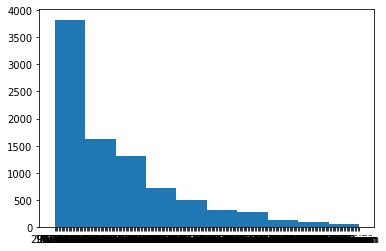

In [22]:
plt.hist(df.duration)